### The Retinal Ganglion Cell (RGC) object

A tutorial introducing the ISETBIO RGC object. 

There are many types of retinal ganglion cells.  We have begun by implementing the core class of RGC with several different types of computations and parameters so that we can mimic the ON/OFF MIDGET/PARASOL and BISTRATIFIED ganglion cell types.

This notebook illustrates how we create an ON-MIDGET and then calculate its response to a bar at several different positions.  In the evil Matlab environment you can make an actual movie.





### A moving bar 

See the script SomethingOrOther for how to create a movie of moving bar.  We will use that as the input.  We have stored that movie on the RemoteDataToolbox site.



In [1]:
rd = RdtClient('isetbio');
rd.crp('/resources/data/istim');
a = rd.listArtifacts;
rdtPrintArtifactTable(a);

***
4 artifacts 
***
              ID              Type            RemPath        
    ______________________    _____    ______________________

    'barMovie'                'mat'    'resources/data/istim'
    'gaborMovie'              'mat'    'resources/data/istim'
    'iStim_NSEM_800fr'        'mat'    'resources/data/istim'
    'iStim_subunitGrating'    'mat'    'resources/data/istim'


In [2]:
% Set up a Gabor stimulus using sceneCreate('harmonic',params)

% Create display
display = displayCreate('CRT-Sony-HorwitzLab');
scene = sceneCreate('empty');
fov = 0.6;
scene = sceneSet(scene, 'h fov', fov);
scene


scene = 

             type: 'scene'
             data: [1x1 struct]
         spectrum: [1x1 struct]
             name: 'empty'
         distance: 1.2000
    magnification: 1
       illuminant: [1x1 struct]
         wAngular: 0.6000


In [3]:
% Create optics and sensor
oi  = oiCreate('wvf human');

% Sensor
params.expTime = 0.01;
params.timeInterval = 0.01;
sensor = sensorCreate('human');
sensor = sensorSetSizeToFOV(sensor, fov, scene, oi);
sensor = sensorSet(sensor, 'exp time', params.expTime); 
sensor = sensorSet(sensor, 'time interval', params.timeInterval); 
sensor

sensor = 

               name: 'human-0'
               type: 'sensor'
              pixel: [1x1 struct]
           spectrum: [1x1 struct]
               rows: 74
               cols: 90
               data: []
       sigmaGainFPN: 0
       gainFPNimage: []
     sigmaOffsetFPN: 0
     offsetFPNimage: []
         analogGain: 1
       analogOffset: 0
       quantization: [1x1 struct]
              human: [1x1 struct]
              color: [1x1 struct]
                cfa: [1x1 struct]
    integrationTime: 0.0100
                 AE: 0
          noiseFlag: 1
                CDS: 0
     mccRectHandles: []


In [4]:
% Movie parameters
params.barwidth = 5;
params.meanLuminance = 200;
params.row = 64; 
params.col = 64;
params.nSteps = 50;     % Number of stimulus frames

% Loop through frames to build movie
fprintf('\nStart');
for t = 1 : params.nSteps
    fprintf('.');
    if t == 1 
        barMovie = zeros(params.row,params.col,3);
    end
    barMovie(:,1+t:t+params.barwidth,:) = 0.5 + 0.499*ones(params.row,params.barwidth,3);
    barMovie(1,1,:) = 0;

    % Generate scene object from stimulus RGB matrix and display object
    scene = sceneFromFile(barMovie, 'rgb', params.meanLuminance, display);

    scene = sceneSet(scene, 'h fov', fov);

    % Get scene RGB data    
    sceneRGB(:,:,t,:) = sceneGet(scene,'rgb');
    
    % Compute optical image
    oi = oiCompute(oi, scene);    
    
    % Compute absorptions
    sensor = sensorCompute(sensor, oi);

    if t == 1
        volts = zeros([sensorGet(sensor, 'size') params.nSteps]);
    end
    volts(:,:,t) = sensorGet(sensor, 'volts');
    
end
fprintf('\nStop\n');

% Set the stimuls into the sensor object
sensor = sensorSet(sensor, 'volts', volts);


Start.[Warning: Using slow poission random variable generation] 
[> In iePoisson (line 93)
  In noiseShot (line 89)
  In sensorAddNoise (line 97)
  In sensorComputeNoise (line 39)
  In sensorCompute (line 190)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
.[Warning: Using slow poission random variable generation] 
[> In iePoisson (line 93)
  In noiseShot (line 89)
  In sensorAddNoise (line 97)
  In sensorComputeNoise (line 39)
  In sensorCompute (line 190)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
.[Warning: Using slow poission random variable generation] 
[> In iePoisson (line 93)
  In noiseShot (line 89)
  In sensorAddNoise (line 97)
  In sensorComputeNoise (line 39)
  In sensorCompute (line 190)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
.[Warning: Using slow poission random variable generation] 
[> In iePoisson (line 93)
  In noiseShot (line 89)
  In sensorAddNoise (line 97)
  In sensorComputeNoise (line 39)
  In sensorCompute (li

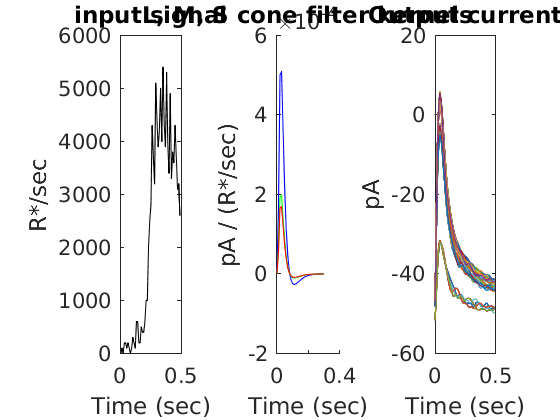

[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.]


In [5]:
% Use the sensor absorptions and create  outer segment photocurrent
os = osCreate('linear');

% Set cone spacing so that 
arrayWidth = sensorGet(sensor,'width');
os = osSet(os, 'patch size', arrayWidth);

% The size of the whole mosaic
% I think there is a function that gets this value, maybe in oiGet.
%  umPerDeg = 300;
%  coneSpacing = scene.wAngular*umPerDeg;

tSampling = sensorGet(sensor,'time interval','sec');
os = osSet(os, 'time step', tSampling);

% os = osSet(os, 'rgbData', sceneRGB);
os = osCompute(os, sensor);

% Plot the photocurrent for a pixel
osPlot(os,sensor);

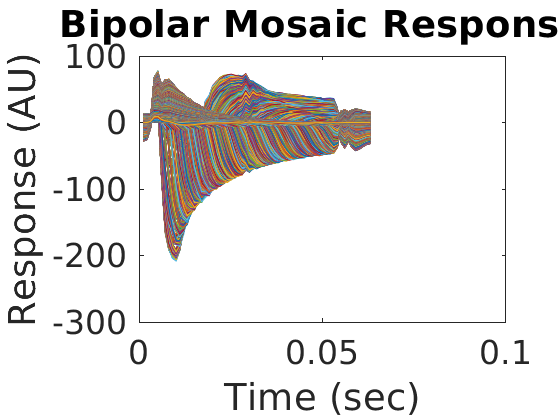

In [6]:


bp = bipolar(os,'filterType',1);
% bp = bipolar(os,cellType,2);

bp = bipolarCompute(bp, os);

bipolarPlot(bp,'response');

In [7]:
%% Build rgc

clear params
params.name      = 'Macaque inner retina 1'; % This instance

params.eyeSide   = 'left';   % Which eye
params.eyeRadius = 4;        % Radius in mm
params.eyeAngle  = 90;       % Polar angle in degrees

innerRetinaSU = irCreate(bp, params);

% innerRetinaSU.mosaicCreate('model','glm','type','off midget');
innerRetinaSU.mosaicCreate('model','glm','type','on midget');
% innerRetinaSU.mosaicCreate('model','glm','type','off parasol');
% innerRetinaSU.mosaicCreate('model','glm','type','on midget');
%% Compute RGC response

innerRetinaSU = irCompute(innerRetinaSU, bp);


Elapsed time is 0.789624 seconds.
     
Spatial Convolution, on midget:     
Elapsed time is 0.295207 seconds.
Temporal Convolution, on midget:     
Elapsed time is 0.161951 seconds.

itrial =

     1


itrial =

     2


itrial =

     3


itrial =

     4


itrial =

     5


itrial =

     6


itrial =

     7


itrial =

     8


itrial =

     9


itrial =

    10


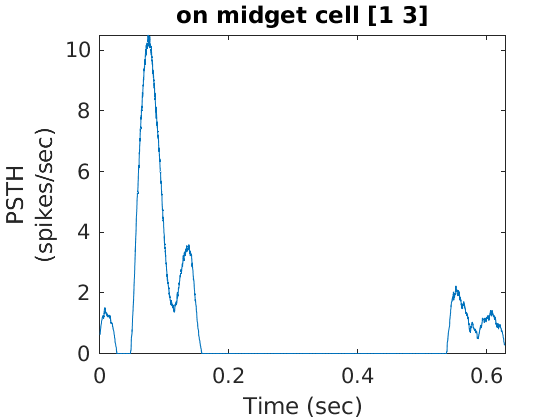

In [8]:

irPlot(innerRetinaSU, 'psth','type',1,'cell',[1 3]);

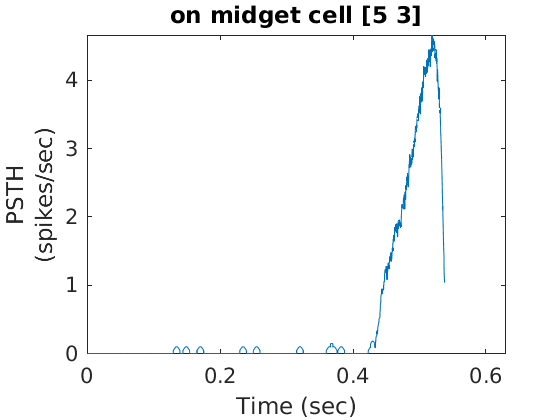

In [9]:
irPlot(innerRetinaSU, 'psth','type',1,'cell',[5 3]);